# Visualization

## Import

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
from flax.training.train_state import TrainState
import optax

from common.cell import to_rgba, to_rgb
from common.pool import Pool
from common.nca import NCA as NCA
from common.utils import load_emoji, load_params, jnp2pil

from omegaconf import OmegaConf
import matplotlib.pyplot as plt

## Load experiment

In [2]:
from pathlib import Path


run_path = Path("/project/output/emoji/2023-08-17_174319_601144")
config = OmegaConf.load(run_path / ".hydra" / "config.yaml")

## Main

In [3]:
# Init a random key
random_key = jax.random.PRNGKey(config.seed)

# Dataset
dataset_phenotypes_target = jnp.stack([load_emoji(emoji, config.exp.emoji_size, config.exp.emoji_padding) for emoji in config.exp.emojis], axis=0)
height, width = dataset_phenotypes_target[0].shape[:2]

# Cell states
cell_state_size = config.exp.phenotype_size + 1 + config.exp.hidden_size

@jax.jit
def phenotype_target_idx_to_genotype(phenotype_target_idx):
	if config.exp.n_emojis == 1:
		return jnp.array([])
	else:
		return jax.nn.one_hot(phenotype_target_idx, num_classes=config.exp.n_emojis)

@jax.jit
def init_cell_state():
	cell_state = jnp.zeros((config.exp.phenotype_size+1+config.exp.hidden_size,))  # init cell_state
	cell_state = cell_state.at[config.exp.phenotype_size:].set(1.0)  # set alpha and hidden channels to 1.0
	return cell_state

@jax.jit
def init_cells_state(_):
	cell_state = init_cell_state()
	cells_state = jnp.zeros((height, width, cell_state_size,))
	return cells_state.at[height//2, width//2].set(cell_state)

# Trainset
trainset_phenotypes_target = dataset_phenotypes_target[:config.exp.n_emojis]
trainset_genotypes_target = jax.vmap(phenotype_target_idx_to_genotype)(jnp.arange(config.exp.n_emojis))

# Pool
phenotypes_target_idx_init = jax.random.choice(random_key, trainset_phenotypes_target.shape[0], shape=(config.exp.pool_size,), replace=True)
cells_states_init = jax.vmap(init_cells_state)(phenotypes_target_idx_init)
genotypes_target_init = jax.vmap(phenotype_target_idx_to_genotype)(phenotypes_target_idx_init)
pool = Pool(cells_states=cells_states_init, phenotypes_target_idx=phenotypes_target_idx_init)

# NCA
nca = NCA(cell_state_size=cell_state_size, n_perceive_free=config.exp.n_perceive_free, update_size=config.exp.update_size, fire_rate=config.exp.fire_rate)
random_key, random_subkey_1, random_subkey_2 = jax.random.split(random_key, 3)
params = nca.init(random_subkey_1, random_subkey_2, cells_states_init[0], genotypes_target_init[0])
params = nca.set_kernel(params)

# Train state
lr_sched = optax.linear_schedule(init_value=config.exp.learning_rate, end_value=0.1*config.exp.learning_rate, transition_steps=2000)

def zero_grads():
	def init_fn(_):
		return ()

	def update_fn(updates, state, params=None):
		return jax.jax.tree_util.tree_map(jnp.zeros_like, updates), ()
	return optax.GradientTransformation(init_fn, update_fn)

optimizer = optax.chain(
	optax.clip_by_global_norm(1.0),
	optax.adam(learning_rate=lr_sched),)
tx = optax.multi_transform({False: optimizer, True: zero_grads()},
							nca.get_perceive_mask(params))

train_state = TrainState.create(
	apply_fn=nca.apply,
	params=params,
	tx=tx)

# Train
@jax.jit
def loss_f(cell_states, phenotype):
	return jnp.mean(jnp.square(to_rgba(cell_states) - phenotype), axis=(-1, -2, -3))

loss_log = []

@jax.jit
def scan_apply(carry, random_key):
	(params, cells_states, genotype_target,) = carry
	cells_states_ = train_state.apply_fn(params, random_key, cells_states, genotype_target)
	return (params, cells_states_, genotype_target,), ()

@partial(jax.jit, static_argnames=("n_iterations",))
def train_step(random_key, train_state, cells_states, genotype_target, phenotypes_target, n_iterations):
	def loss_fn(params):
		random_keys = jax.random.split(random_key, n_iterations)
		(params, cells_states_, _,), _ = jax.lax.scan(scan_apply, (params, cells_states, genotype_target,), random_keys, length=n_iterations)
		return loss_f(cells_states_, phenotypes_target).mean(), cells_states_

	(loss, cells_states_), grads = jax.value_and_grad(loss_fn, has_aux=True)(train_state.params)
	train_state = train_state.apply_gradients(grads=grads)

	return train_state, loss, cells_states_

## Load NCA

In [4]:
i = 43800
params = load_params(params, run_path / "nca_{:07d}.pickle".format(i))

train_state = TrainState.create(
    apply_fn=nca.apply,
    params=params,
    tx=tx)

## Visualize

In [43]:
n_iterations = 500
index = 5
cells_state = init_cells_state(None)
phenotype_target = trainset_phenotypes_target[index]
genotype_target = trainset_genotypes_target[index]

random_keys = jax.random.split(random_key, n_iterations)
(params, cells_state_, _,), _ = jax.lax.scan(
    scan_apply,
    (params, cells_state, genotype_target,),
    random_keys,
    length=n_iterations,)

In [228]:
n_iterations = 200
cells_state = init_cells_state(None)
genotype_target = jnp.array([0, 0, 0, 0.2, 0, 0, 0, 0.8, 0, 0])
random_keys = jax.random.split(random_key, n_iterations)
(params, cells_state_, _,), _ = jax.lax.scan(
    scan_apply,
    (params, cells_state, genotype_target,),
    random_keys,
    length=n_iterations,)

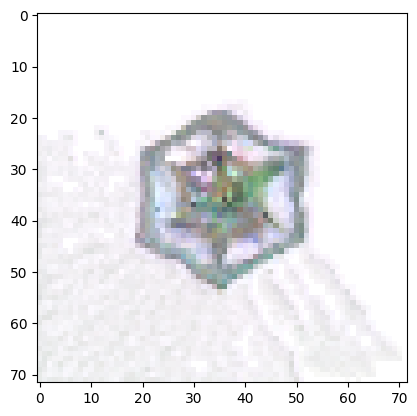

In [229]:
plt.imshow(jnp2pil(to_rgb(cells_state_)))